In [1]:
import pandas as pd

In [2]:
X_train = pd.read_feather('with_dates_X_train')
y_train = pd.read_feather('with_dates_y_train')
X_train = X_train.drop(columns = 'index')
y_train = y_train.drop(columns = 'index')

In [3]:
X_val = pd.read_feather('with_dates_X_validate')
y_val = pd.read_feather('with_dates_y_validate')
X_val = X_val.drop(columns = 'index')
y_val = y_val.drop(columns = 'index')

In [6]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr = rfr.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
rfr.score(X_val, y_val)

0.6759528331863012

In [9]:
importance_numbers = rfr.feature_importances_
importance_list = importance_numbers.tolist()

In [13]:
import numpy as np
feature_names = (X_train.columns)
importances = np.vstack((feature_names, importance_list))

In [17]:
importances = pd.Series(importance_list, index = X_train.columns)

In [24]:
importances.sort_values(ascending = False).head(10)

Fascinating_ratings     0.262306
OK_ratings              0.196938
Informative_ratings     0.151265
Inspiring_ratings       0.120373
Funny_ratings           0.063010
Courageous_ratings      0.032197
Persuasive_ratings      0.025465
languages               0.019891
Jaw-dropping_ratings    0.019723
Beautiful_ratings       0.016325
dtype: float64

In [51]:
selected_importances = list(importances.sort_values(ascending = False).head(7).index)

In [52]:
selected_importances

['Fascinating_ratings',
 'OK_ratings',
 'Informative_ratings',
 'Inspiring_ratings',
 'Funny_ratings',
 'Courageous_ratings',
 'Persuasive_ratings']

In [53]:
X_train_importances = X_train[selected_importances]

In [54]:
X_val_importances = X_val[selected_importances]

In [55]:
from sklearn.ensemble import RandomForestRegressor
rfr_selected = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_selected = rfr_selected.fit(X_train_importances, y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
rfr_selected.score(X_val_importances, y_val)

0.6514673434583245

With the top seven features found using sk_learn's feature_importances, my forest had a score of ~0.651 on my validation set.

In [58]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfr).fit(X_val, y_val)
eli5.show_weights(perm, feature_names=list(X_train.columns))

Weight,Feature
0.1787 ± 0.0287,Fascinating_ratings
0.1429 ± 0.0088,OK_ratings
0.0781 ± 0.0323,Informative_ratings
0.0560 ± 0.0117,Inspiring_ratings
0.0402 ± 0.0136,Funny_ratings
0.0195 ± 0.0066,languages
0.0116 ± 0.0051,Persuasive_ratings
0.0110 ± 0.0130,Jaw-dropping_ratings
0.0104 ± 0.0075,Beautiful_ratings
0.0087 ± 0.0013,Ingenious_ratings


In [59]:
perm_features = ['Fascinating_ratings', 'OK_ratings', 'Informative_ratings', 'Inspiring_ratings', 'Funny_ratings', 
                 'languages', 'Persuasive_ratings']

In [60]:
X_train_perm = X_train[perm_features]

In [61]:
X_val_perm = X_val[perm_features]

In [63]:
from sklearn.ensemble import RandomForestRegressor
rfr_perm = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_perm = rfr_perm.fit(X_train_perm, y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
rfr_perm.score(X_val_perm, y_val)

0.6533897017386741

With the top seven features found using eli5's Permuation Importance function, my forest had a score of ~0.653 on my validation set. <br>
Because this score is slightly higher, and I find eli5's interface easier to use, I will use eli5 to evaluate feature importance. <br>

In [66]:
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rfr).fit(X_val, y_val)

In [68]:
eli5.explain_weights_df(perm, feature_names = X_val.columns.to_list()).head(5)

,feature,weight,std
0,Fascinating_ratings,0.173615,0.023498
1,OK_ratings,0.141729,0.003730
2,Informative_ratings,0.089135,0.002188
3,Inspiring_ratings,0.059289,0.007392
4,Funny_ratings,0.042204,0.003518


In [127]:
from sklearn.feature_selection import SelectFromModel
first_selection = SelectFromModel(perm, threshold=0.01, prefit=True)
X_val_first_select = first_selection.transform(X_val)
X_train_first_select = first_selection.transform(X_train)

In [128]:
rfr_first_select = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_first_select.fit(X_train_first_select, y_train)
rfr_first_select.score(X_val_first_select, y_val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.6509633414840348

In [85]:
first_select_cols = X_train.columns[first_selection.get_support()]
first_select_cols[:5]

Index(['languages', 'Funny_ratings', 'Beautiful_ratings',
       'Informative_ratings', 'Fascinating_ratings'],
      dtype='object')

In [86]:
first_select_cols.shape

(9,)

In [87]:
from eli5.sklearn import PermutationImportance
second_pmi = PermutationImportance(rfr_first_select).fit(X_val_first_select, y_val)

In [89]:
eli5.explain_weights_df(second_pmi, feature_names = first_select_cols.to_list())

,feature,weight,std
0,OK_ratings,0.157137,0.006151
1,Fascinating_ratings,0.148614,0.011931
2,Informative_ratings,0.105229,0.002881
3,Inspiring_ratings,0.068136,0.002326
4,Funny_ratings,0.042616,0.002592
5,languages,0.023567,0.006228
6,Jaw-dropping_ratings,0.017461,0.005026
7,Beautiful_ratings,0.015476,0.003248
8,Persuasive_ratings,0.010744,0.001498


Since all features currently meet the 1% cutoff, after 1 round my feature selection by permutation weight is complete. 

In [108]:
X_train_first_select_df = pd.DataFrame(X_train_first_select, columns = first_select_cols)

In [111]:
X_train_first_select_df = X_train_first_select_df.astype('int64')

In [141]:
X_val_first_select_df = pd.DataFrame(X_val_first_select, columns = first_select_cols)

In [142]:
X_val_first_select_df = X_val_first_select_df.astype('int64')

In [113]:
import numpy as np
indexed_corr = (np.abs(X_train_first_select_df.corr(method = 'spearman')) > .60).sum()
correlated_cols = indexed_corr[indexed_corr > 1].index
correlated_cols

Index(['Beautiful_ratings', 'Informative_ratings', 'Fascinating_ratings',
       'Persuasive_ratings', 'Jaw-dropping_ratings', 'Inspiring_ratings'],
      dtype='object')

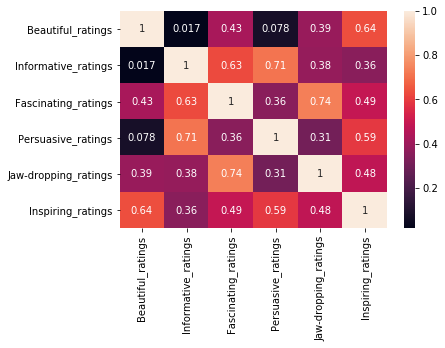

In [115]:
import seaborn as sns
df_corr = X_train_first_select_df[correlated_cols].corr(method = 'spearman')
sns.heatmap(df_corr, annot = True);

There are four sets of features with spearman correlations greater than 0.6:
1. Fascinating_ratings and Jaw-dropping_ratings
2. Persuasive_ratings and Informative_ratings
3. Beautiful_ratings and Inspiring_ratings
4. Fascinating_ratings and Informative_ratings

I will now go through these sets of features to decide which one to remove.

## 1. Fascinating_ratings and Jaw-dropping_ratings

In [143]:
dropped_fascinating_train = X_train_first_select_df.drop(columns = ['Fascinating_ratings'])
dropped_fascinating_val = X_val_first_select_df.drop(columns = ['Fascinating_ratings'])

rfr_dropped_fascinating = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_dropped_fascinating.fit(dropped_fascinating_train, y_train)
rfr_dropped_fascinating.score(dropped_fascinating_val, y_val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.6424827853300201

In [144]:
dropped_jawdropping_train = X_train_first_select_df.drop(columns = ['Jaw-dropping_ratings'])
dropped_jawdropping_val = X_val_first_select_df.drop(columns = ['Jaw-dropping_ratings'])

rfr_dropped_jawdropping = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_dropped_jawdropping.fit(dropped_jawdropping_train, y_train)
rfr_dropped_jawdropping.score(dropped_jawdropping_val, y_val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.6519142815449135

Removing the Jaw-dropping_ratings column does not result in a significant reduction in score, so I will remove that column moving forward.

## 2. Persuasive_ratings and Informative_ratings

In [145]:
dropped_persuasive_train = dropped_jawdropping_train.drop(columns = ['Persuasive_ratings'])
dropped_persuasive_val = dropped_jawdropping_val.drop(columns = ['Persuasive_ratings'])

rfr_dropped_persuasive = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_dropped_persuasive.fit(dropped_persuasive_train, y_train)
rfr_dropped_persuasive.score(dropped_persuasive_val, y_val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.6476686717092313

In [146]:
dropped_informative_train = dropped_jawdropping_train.drop(columns = ['Informative_ratings'])
dropped_informative_val = dropped_jawdropping_val.drop(columns = ['Informative_ratings'])

rfr_dropped_informative = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_dropped_informative.fit(dropped_informative_train, y_train)
rfr_dropped_informative.score(dropped_informative_val, y_val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.6142310556515291

Removing the Persuaive_ratings doesn't result in a significant drop in score, so it is safe to remove that feature. <br>

## 3. Beautiful_ratings and Inspiring_ratings

In [147]:
dropped_beautiful_train = dropped_persuasive_train.drop(columns = ['Beautiful_ratings'])
dropped_beautiful_val = dropped_persuasive_val.drop(columns = ['Beautiful_ratings'])

rfr_dropped_beautiful = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_dropped_beautiful.fit(dropped_beautiful_train, y_train)
rfr_dropped_beautiful.score(dropped_beautiful_val, y_val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.6505868159178618

In [148]:
dropped_inspiring_train = dropped_persuasive_train.drop(columns = ['Inspiring_ratings'])
dropped_inspiring_val = dropped_persuasive_val.drop(columns = ['Inspiring_ratings'])

rfr_dropped_inspiring = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_dropped_inspiring.fit(dropped_inspiring_train, y_train)
rfr_dropped_inspiring.score(dropped_inspiring_val, y_val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.6463705449946373

Dropping the Beautiful_ratings column resulted in a slight increase in the score, so I decided to drop the feature from my model. <br>

## 4. Fascinating_ratings and Informative_ratings
Since both of these columns were included in previous analyses that resulted in a column being dropped, I believe attempting to remove one of them, will result in a significant decrease in score. 

In [149]:
dropped_fascinating_train = dropped_beautiful_train.drop(columns = ['Fascinating_ratings'])
dropped_fascinating_val = dropped_beautiful_val.drop(columns = ['Fascinating_ratings'])

rfr_dropped_fascinating = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_dropped_fascinating.fit(dropped_fascinating_train, y_train)
rfr_dropped_fascinating.score(dropped_fascinating_val, y_val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.6332925438998525

In [150]:
dropped_informative_train = dropped_beautiful_train.drop(columns = ['Informative_ratings'])
dropped_informative_val = dropped_beautiful_val.drop(columns = ['Informative_ratings'])

rfr_dropped_informative = RandomForestRegressor(n_estimators = 21, max_features='auto', min_samples_leaf=5, random_state = 35)
rfr_dropped_informative.fit(dropped_informative_train, y_train)
rfr_dropped_informative.score(dropped_informative_val, y_val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.6194618237793297

As I expected, trying to remove either of these columns results in a significant decrease in score (either 2% or 4%), so I decided to keep both columns in my model. <br>

The final features that I have selected for inclusion in my model are:
1. languages
2. Funny_ratings
3. Informative_ratings
4. Fascinating_ratings
5. OK_ratings
6. Inspiring_ratings

In [151]:
dropped_beautiful_train.columns

Index(['languages', 'Funny_ratings', 'Informative_ratings',
       'Fascinating_ratings', 'OK_ratings', 'Inspiring_ratings'],
      dtype='object')

In [152]:
dropped_beautiful_train.to_feather('X_train_selected')

In [153]:
dropped_beautiful_val.to_feather('X_val_selected')